In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


Loading training data...
Loading test data...

Dataset Statistics:
Training set shape: (22967, 48, 48, 1) (80.0% of total)
Validation set shape: (5742, 48, 48, 1) (20.0% of total)
Test set shape: (7178, 48, 48, 1)


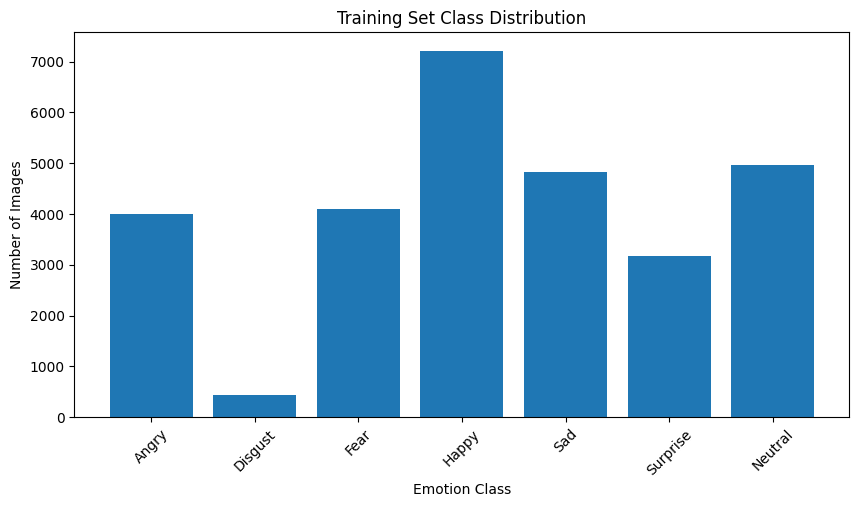

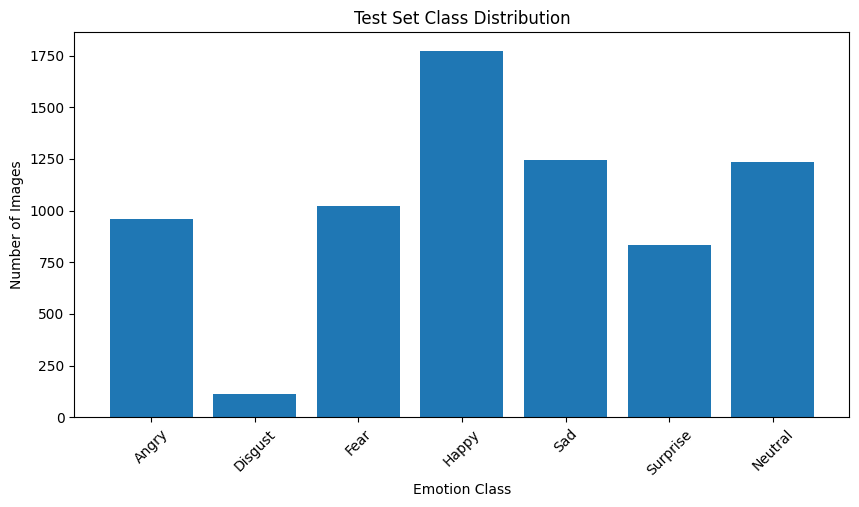

In [2]:

# Define paths
train_path = r'C:\Users\yrick\OneDrive\Desktop\emotional_intelligence_system\data sets\archive\train'
test_path = r'C:\Users\yrick\OneDrive\Desktop\emotional_intelligence_system\data sets\archive\test'

# Emotion labels
emotion_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

def load_dataset(dataset_path):
    images = []
    labels = []
    
    for emotion_num, emotion_name in emotion_labels.items():
        emotion_path = os.path.join(dataset_path, emotion_name)
        
        # Check if directory exists
        if not os.path.isdir(emotion_path):
            print(f"Warning: Directory {emotion_path} not found. Skipping...")
            continue
            
        for img_file in os.listdir(emotion_path):
            if img_file.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(emotion_path, img_file)
                
                try:
                    # Read and preprocess image
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (48, 48))
                    
                    # Normalize pixel values
                    img = img / 255.0
                    
                    images.append(img)
                    labels.append(emotion_num)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    
    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

# Load training and test data
print("Loading training data...")
train_images, train_labels = load_dataset(train_path)
print("Loading test data...")
test_images, test_labels = load_dataset(test_path)

# Reshape images for CNN input
train_images = train_images.reshape(-1, 48, 48, 1)
test_images = test_images.reshape(-1, 48, 48, 1)

# One-hot encode labels
train_labels = to_categorical(train_labels, num_classes=7)
test_labels = to_categorical(test_labels, num_classes=7)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_images, 
    train_labels, 
    test_size=0.2, 
    random_state=42,
    stratify=train_labels  # Maintain class distribution
)

print("\nDataset Statistics:")
print(f"Training set shape: {X_train.shape} ({(X_train.shape[0]/len(train_images)*100):.1f}% of total)")
print(f"Validation set shape: {X_val.shape} ({(X_val.shape[0]/len(train_images)*100):.1f}% of total)")
print(f"Test set shape: {test_images.shape}")

# Visualize class distribution
def plot_class_distribution(labels, title):
    class_counts = np.sum(labels, axis=0)
    plt.figure(figsize=(10, 5))
    plt.bar(emotion_labels.values(), class_counts)
    plt.title(title)
    plt.xlabel('Emotion Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_labels, 'Training Set Class Distribution')
plot_class_distribution(test_labels, 'Test Set Class Distribution')

In [3]:
# Create data generator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen.fit(X_train)

In [4]:
def create_model():
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # Second Conv Block
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # Third Conv Block
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))
    
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [5]:
# Define optimizer
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [6]:
# Callbacks
checkpoint = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

In [7]:
# Training parameters
batch_size = 64
epochs = 100

# Train the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/100
358/358 [==============================] - ETA: 0s - loss: 2.8018 - accuracy: 0.1969
Epoch 1: val_accuracy improved from -inf to 0.14141, saving model to best_model.h5
358/358 [==============================] - 494s 1s/step - loss: 2.8018 - accuracy: 0.1969 - val_loss: 2.1296 - val_accuracy: 0.1414 - lr: 1.0000e-04
Epoch 2/100
358/358 [==============================] - ETA: 0s - loss: 2.4281 - accuracy: 0.2321
Epoch 2: val_accuracy improved from 0.14141 to 0.34013, saving model to best_model.h5
358/358 [==============================] - 489s 1s/step - loss: 2.4281 - accuracy: 0.2321 - val_loss: 1.7518 - val_accuracy: 0.3401 - lr: 1.0000e-04
Epoch 3/100
358/358 [==============================] - ETA: 0s - loss: 2.2476 - accuracy: 0.2561
Epoch 3: val_accuracy improved from 0.34013 to 0.36068, saving model to best_model.h5
358/358 [==============================] - 464s 1s/step - loss: 2.2476 - accuracy: 0.2561 - val_loss: 1.6942 - val_accuracy: 0.3607 - lr: 1.0000e-04
Epoch 4

225/225 [==============================] - 31s 137ms/step - loss: 0.9622 - accuracy: 0.6500
Test Accuracy: 65.00%
225/225 [==============================] - 31s 136ms/step
              precision    recall  f1-score   support

       Angry       0.57      0.58      0.58       958
     Disgust       0.64      0.39      0.48       111
        Fear       0.62      0.33      0.43      1024
       Happy       0.84      0.87      0.86      1774
         Sad       0.54      0.49      0.52      1247
    Surprise       0.76      0.78      0.77       831
     Neutral       0.52      0.75      0.61      1233

    accuracy                           0.65      7178
   macro avg       0.64      0.60      0.61      7178
weighted avg       0.65      0.65      0.64      7178



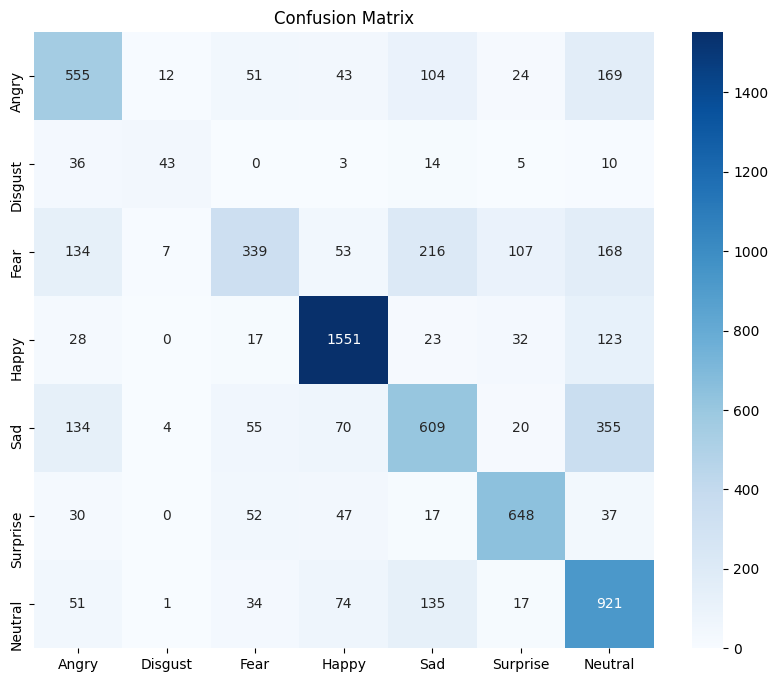

In [8]:
# Load the best saved model
model.load_weights('best_model.h5')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test Accuracy: {test_acc*100:.2f}%')

# Generate predictions
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']))

# Confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
            yticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
plt.title('Confusion Matrix')
plt.show()

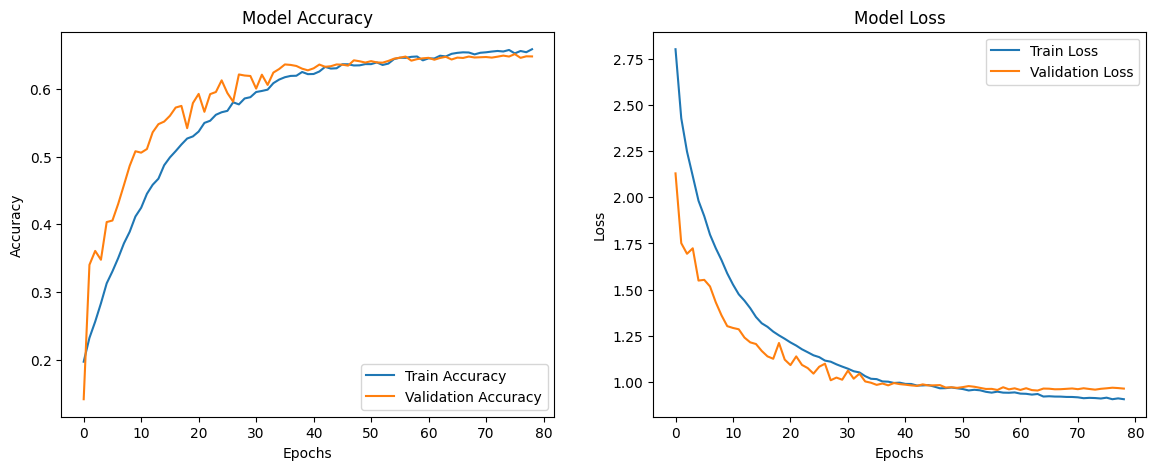

In [9]:
# Plot accuracy and loss
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
# Save the final model
model.save('ML_Model/emotion_detection_model.h5')

# Convert to TensorFlow Lite for mobile deployment (optional)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('emotion_detection.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\yrick\AppData\Local\Temp\tmp0f8ov_lr\assets


INFO:tensorflow:Assets written to: C:\Users\yrick\AppData\Local\Temp\tmp0f8ov_lr\assets


In [11]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, 
                            confusion_matrix, classification_report)
from sklearn.preprocessing import label_binarize  # Added this import
import seaborn as sns
import numpy as np
import json
from math import pi  # For radar chart


# Create Evaluation_Metrics directory if it doesn't exist
os.makedirs('Evaluation_Metrics', exist_ok=True)

# Set professional style for all plots
plt.style.use('seaborn')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# 1. Enhanced ROC Curve (Multi-class)
def save_roc_curve(y_true, y_pred):
    y_true_bin = label_binarize(y_true, classes=range(7))
    fpr, tpr, roc_auc = {}, {}, {}
    
    plt.figure(figsize=(12, 8))
    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2.5, 
                label=f'{emotion_labels[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Multiclass ROC Curves', fontsize=14, pad=20)
    plt.legend(loc="lower right", frameon=True, bbox_to_anchor=(1.4, 0))
    plt.tight_layout()
    plt.savefig('Evaluation_Metrics/ROC_Curve.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Save ROC AUC values
    with open('Evaluation_Metrics/roc_auc_values.json', 'w') as f:
        json.dump({emotion_labels[i]: float(roc_auc[i]) for i in range(7)}, f)

# 2. Precision-Recall Curve with F1 contours
def save_pr_curve(y_true, y_pred):
    y_true_bin = label_binarize(y_true, classes=range(7))
    precision, recall, pr_auc = {}, {}, {}
    
    plt.figure(figsize=(12, 8))
    for i in range(7):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
        pr_auc[i] = auc(recall[i], precision[i])
        plt.plot(recall[i], precision[i], lw=2.5, 
                label=f'{emotion_labels[i]} (AUC = {pr_auc[i]:.2f})')
    
    # Add F1-score contours
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2, linestyle='--')
        plt.annotate(f'F1={f_score:.1f}', xy=(0.9, y[-1] + 0.02), alpha=0.5)
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves with F1 Contours', fontsize=14, pad=20)
    plt.legend(loc="upper right", frameon=True, bbox_to_anchor=(1.4, 1))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.tight_layout()
    plt.savefig('Evaluation_Metrics/PR_Curve.png', dpi=300, bbox_inches='tight')
    plt.close()

# 3. Enhanced Confusion Matrix
def save_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm_norm, 
               annot=True, 
               fmt='.2f', 
               cmap='Blues',
               annot_kws={'size': 10},
               xticklabels=emotion_labels.values(),
               yticklabels=emotion_labels.values(),
               linewidths=0.5,
               cbar_kws={'shrink': 0.75})
    
    plt.title('Normalized Confusion Matrix', fontsize=16, pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('Evaluation_Metrics/Confusion_Matrix.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Save raw confusion matrix
    np.save('Evaluation_Metrics/confusion_matrix_raw.npy', cm)

# 4. Class Distribution Radar Chart
def save_radar_chart(y_true, y_pred):
    from math import pi
    
    true_counts = np.bincount(y_true, minlength=7)
    pred_counts = np.bincount(y_pred, minlength=7)
    
    categories = list(emotion_labels.values())
    N = len(categories)
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    
    # True distribution
    true_values = true_counts / true_counts.sum()
    true_values = np.append(true_values, true_values[0])
    ax.plot(angles, true_values, linewidth=2, linestyle='solid', 
           label='True Distribution', color='#3498db')
    ax.fill(angles, true_values, '#3498db', alpha=0.1)
    
    # Predicted distribution
    pred_values = pred_counts / pred_counts.sum()
    pred_values = np.append(pred_values, pred_values[0])
    ax.plot(angles, pred_values, linewidth=2, linestyle='solid', 
           label='Predicted Distribution', color='#e74c3c')
    ax.fill(angles, pred_values, '#e74c3c', alpha=0.1)
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories, color='grey', size=12)
    ax.set_rlabel_position(0)
    plt.yticks([0.1, 0.2, 0.3, 0.4], ["10%", "20%", "30%", "40%"], color="grey", size=10)
    plt.ylim(0, 0.5)
    plt.title('Class Distribution Radar Chart', size=16, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.savefig('Evaluation_Metrics/Radar_Chart.png', dpi=300, bbox_inches='tight')
    plt.close()

# 5. Enhanced F1-Score by Class with Error Bars
def save_f1_scores(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    metrics = {
        'precision': [report[str(i)]['precision'] for i in range(7)],
        'recall': [report[str(i)]['recall'] for i in range(7)],
        'f1-score': [report[str(i)]['f1-score'] for i in range(7)],
        'support': [report[str(i)]['support'] for i in range(7)]
    }
    
    x = np.arange(7)
    width = 0.25
    
    plt.figure(figsize=(14, 8))
    rects1 = plt.bar(x - width, metrics['precision'], width, label='Precision', color='#2ecc71')
    rects2 = plt.bar(x, metrics['recall'], width, label='Recall', color='#e67e22')
    rects3 = plt.bar(x + width, metrics['f1-score'], width, label='F1-Score', color='#9b59b6')
    
    # Add value labels
    for rects, offset in zip([rects1, rects2, rects3], [-width, 0, width]):
        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2. + offset, height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.xlabel('Emotion Class', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Precision, Recall and F1-Score by Class', fontsize=14, pad=20)
    plt.xticks(x, emotion_labels.values())
    plt.legend(loc='upper right', frameon=True)
    plt.ylim(0, 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('Evaluation_Metrics/F1_Scores.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Save full classification report
    with open('Evaluation_Metrics/classification_report.json', 'w') as f:
        json.dump(report, f, indent=4)

# 6. Prediction Confidence Distribution
def save_confidence_distribution(y_true, y_pred):
    plt.figure(figsize=(14, 8))
    for i in range(7):
        class_mask = y_true == i
        if np.any(class_mask):
            confidences = y_pred[class_mask, i]
            sns.kdeplot(confidences, label=emotion_labels[i], lw=2.5)
    
    plt.title('Prediction Confidence Distribution by Class', fontsize=14, pad=20)
    plt.xlabel('Model Confidence', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(title='Emotion Class')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.savefig('Evaluation_Metrics/Confidence_Distribution.png', dpi=300, bbox_inches='tight')
    plt.close()

# Generate and save all plots
print("\n\033[1mGenerating Comprehensive Evaluation Metrics...\033[0m")
save_roc_curve(y_true, y_pred)
save_pr_curve(y_true, y_pred)
save_confusion_matrix(y_true, y_pred_classes)
save_radar_chart(y_true, y_pred_classes)
save_f1_scores(y_true, y_pred_classes)
save_confidence_distribution(y_true, y_pred)

print("\n\033[1mAll evaluation metrics saved to Evaluation_Metrics folder:\033[0m")
print(os.listdir('Evaluation_Metrics'))

C:\Users\yrick\AppData\Local\Temp\ipykernel_27520\3242762299.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')



Generating Comprehensive Evaluation Metrics...

All evaluation metrics saved to Evaluation_Metrics folder:
['classification_report.json', 'Confidence_Distribution.png', 'Confusion_Matrix.png', 'confusion_matrix_raw.npy', 'F1_Scores.png', 'PR_Curve.png', 'Radar_Chart.png', 'roc_auc_values.json', 'ROC_Curve.png']
